In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
trainDf=pd.read_csv("train.csv")
print(trainDf.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

In [5]:
print(trainDf.shape)

(42000, 785)


In [6]:
y_train=trainDf["label"].values
X_train=trainDf.iloc[:,1:].values.reshape(-1,28,28)
X_train=X_train.astype(np.float32)/255.0
print(f"Size of y_train : {len(y_train)}\nSize of X_train : {X_train.shape}\n")

Size of y_train : 42000
Size of X_train : (42000, 28, 28)



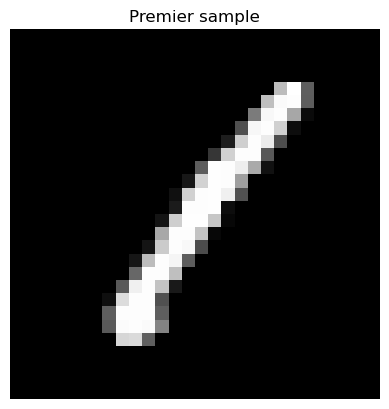

In [12]:
plt.imshow(X_train[0],cmap="gray")
plt.title("Premier sample")
plt.axis("off")
plt.show()

In [9]:
def padding(img,pad_size=0):
    if pad_size==0:
        return img
    else:
        newImg=np.zeros((img.shape[0]+2*pad_size,img.shape[1]+2*pad_size))
        for w in range(pad_size,newImg.shape[0]-pad_size):
            for h in range(pad_size,newImg.shape[1]-pad_size):
                newImg[w][h]=img[w-pad_size][h-pad_size]
        return newImg

In [28]:
def conv2d(img,kernel,pad_size=0,stride=1): #on part du principe que chaque img est carrée -> 28x28 dans ce cas
    padded=padding(img,pad_size)
    print(f"Padded : {padded.shape}")
    newImg=np.zeros((((padded.shape[0]-kernel.shape[0])//stride)+1,((padded.shape[1]-kernel.shape[1])//stride)+1))
    print(newImg.shape)
    """for w in range(kernel.shape[0]):
        for h in range(kernel.shape[1]):"""


In [29]:
kernel=np.array([
    [1,2,3],
    [4,5,6],
    [7,8,9]
])
print(kernel.shape)
conv2d(X_train[0],kernel,pad_size=1)

(3, 3)
Padded : (30, 30)
(28, 28)
